In [62]:
import practicalSPARQL
import pandas as pd
import ast
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import seaborn as sns

In [63]:
root_q = 'queries'
root_d = 'results'

# read login data
login = pd.read_json('config_sparql.json')
ENDPOINT = login['endpoint'][0]
USERNAME = login['username'][0]
PASSWORD = login['password'][0]

# create sparql object
sparql = practicalSPARQL.practicalWrapper(ENDPOINT)
sparql.setCredentials(USERNAME, PASSWORD)

print("--- Querying ENDPOINT: {} ---".format(ENDPOINT))

--- Querying ENDPOINT: http://devmeta.sphaera.mpiwg-berlin.mpg.de/sparql ---


In [64]:
q = practicalSPARQL.stringify_SPARQL('books_query.sparql')    # select data from the ttl file as a dataframe
books = sparql.select_as_dataframe(q)

In [65]:
q = practicalSPARQL.stringify_SPARQL('elements_query_050824.sparql')    # select data from the ttl file as a dataframe
df = sparql.select_as_dataframe(q)

In [105]:
# Perform a left merge on 'book' to add the corresponding columns from df to books (excluding images_per_page for now)
merged_df = pd.merge(books, df[['book', 'images', 'cluster_name', 'cks', 'custom_identifier']], 
                     on='book', how='left')

# Fill NaN values with specific defaults (optional)
merged_df['cluster_name'] = merged_df['cluster_name'].fillna('Unknown')
merged_df['cks'] = merged_df['cks'].fillna('Unknown')
merged_df['custom_identifier'] = merged_df['custom_identifier'].fillna('Unknown')

merged_df

,book,label,bid,authors,publishers,printers,place,year,num_pages,images,cluster_name,cks,custom_identifier
0,http://sphaera.mpiwg-berlin.mpg.de/id/item/b49...,Sphaera mundi,1926,"Peurbach, Georg von;Regiomontanus, Johannes;Sa...","Trino, Guglielmo da","Trino, Guglielmo da",Venice,1491,96,http://db.sphaera.mpiwg-berlin.mpg.de/containe...,SAC_SIL_00831,"CK_Superior Planets Lines and Motion, CK_Venus...",104
1,http://sphaera.mpiwg-berlin.mpg.de/id/item/b49...,Sphaera mundi,1926,"Peurbach, Georg von;Regiomontanus, Johannes;Sa...","Trino, Guglielmo da","Trino, Guglielmo da",Venice,1491,96,http://db.sphaera.mpiwg-berlin.mpg.de/containe...,SAC_SIL_00495,CK_Superior Planets Proportional Minutes,104
2,http://sphaera.mpiwg-berlin.mpg.de/id/item/b49...,Sphaera mundi,1926,"Peurbach, Georg von;Regiomontanus, Johannes;Sa...","Trino, Guglielmo da","Trino, Guglielmo da",Venice,1491,96,http://db.sphaera.mpiwg-berlin.mpg.de/containe...,SAC_SIL_01876,"CK_Circles of Equant Deferent Epicycle, CK_Lun...",104
3,http://sphaera.mpiwg-berlin.mpg.de/id/item/b49...,Sphaera mundi,1926,"Peurbach, Georg von;Regiomontanus, Johannes;Sa...","Trino, Guglielmo da","Trino, Guglielmo da",Venice,1491,96,http://db.sphaera.mpiwg-berlin.mpg.de/containe...,SAC_SIL_01810,"CK_Superior Planets Lines and Motion, CK_Venus...",104
4,http://sphaera.mpiwg-berlin.mpg.de/id/item/b49...,Sphaera mundi,1926,"Peurbach, Georg von;Regiomontanus, Johannes;Sa...","Trino, Guglielmo da","Trino, Guglielmo da",Venice,1491,96,http://db.sphaera.mpiwg-berlin.mpg.de/containe...,SAC_SIL_01967,"CK_Sun Orbit, CK_Sun Axis and Poles",104
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20966,http://sphaera.mpiwg-berlin.mpg.de/id/item/ba9...,In Sphaeram Ioannis de Sacro Bosco Commentarius,2278,"Sacrobosco, Johannes de;Clavius, Christoph","Ciotti, Giovanni Battista","Ciotti, Giovanni Battista",Venice,1601,512,http://www.researchspace.org/ontology/ImageReg...,SAC_SIL_01863,CK_Conical Shape of Planetary Shadow,295
20967,http://sphaera.mpiwg-berlin.mpg.de/id/item/ba9...,In Sphaeram Ioannis de Sacro Bosco Commentarius,2278,"Sacrobosco, Johannes de;Clavius, Christoph","Ciotti, Giovanni Battista","Ciotti, Giovanni Battista",Venice,1601,512,http://www.researchspace.org/ontology/ImageReg...,SAC_SIL_01792,CK_Stationary and Retrograde Motion,295
20968,http://sphaera.mpiwg-berlin.mpg.de/id/item/ba9...,In Sphaeram Ioannis de Sacro Bosco Commentarius,2278,"Sacrobosco, Johannes de;Clavius, Christoph","Ciotti, Giovanni Battista","Ciotti, Giovanni Battista",Venice,1601,512,http://www.researchspace.org/ontology/ImageReg...,SAC_SIL_01516,CK_Parallax,295
20969,http://sphaera.mpiwg-berlin.mpg.de/id/item/ba9...,In Sphaeram Ioannis de Sacro Bosco Commentarius,2278,"Sacrobosco, Johannes de;Clavius, Christoph","Ciotti, Giovanni Battista","Ciotti, Giovanni Battista",Venice,1601,512,http://www.researchspace.org/ontology/ImageReg...,SAC_SIL_02102,CK_Parallax,295


In [106]:
#add a column with images per page data

# Step 1: Ensure 'num_pages' column is of type int
merged_df['num_pages'] = pd.to_numeric(merged_df['num_pages'], errors='coerce', downcast='integer')

# Step 2: Calculate the number of unique 'images' per 'book' and divide by 'num_pages'
# Group by 'book' to count unique images, then divide by 'num_pages' for each book
merged_df['images_per_page'] = merged_df.groupby('book')['images'].transform(lambda x: x.nunique() if x.nunique() > 0 else 0) / merged_df['num_pages']

# Step 3: Handle NaN values - books with no images or missing page counts
merged_df['images_per_page'] = merged_df['images_per_page'].fillna(0)

# Optional: Ensure books with no images (or no 'images' data) get a value of 0
merged_df.loc[merged_df['images_per_page'] == float('inf'), 'images_per_page'] = 0  # Handle division by zero

Cluster 0: Min = 0.0, Max = 0.48214285714285715
Cluster 1: Min = 1.2962962962962963, Max = 1.935483870967742
Cluster 2: Min = 0.49101796407185627, Max = 1.1020408163265305


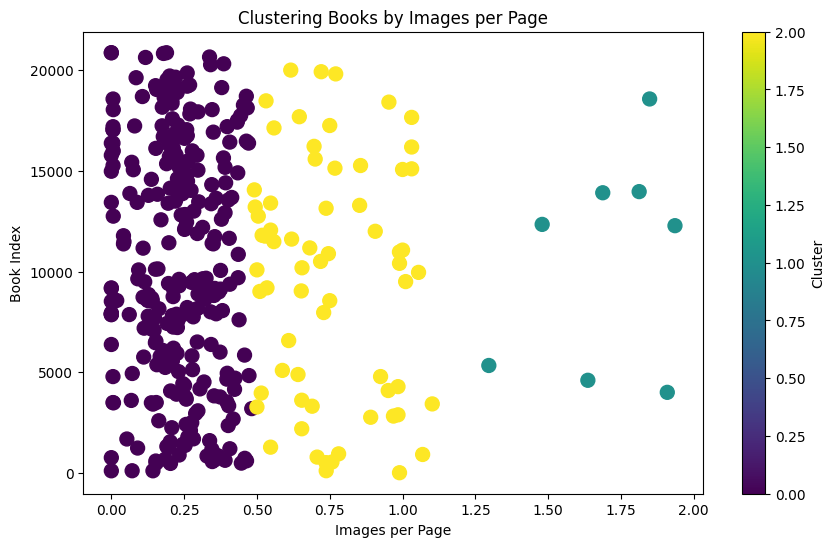

In [109]:
# Step 2: Perform KMeans clustering with 4 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
book_images_per_page['cluster'] = kmeans.fit_predict(book_images_per_page[['images_per_page']])

# Step 3: Print the range of 'images_per_page' for each cluster
for cluster in sorted(book_images_per_page['cluster'].unique()):
    cluster_data = book_images_per_page[book_images_per_page['cluster'] == cluster]
    min_value = cluster_data['images_per_page'].min()
    max_value = cluster_data['images_per_page'].max()
    print(f"Cluster {cluster}: Min = {min_value}, Max = {max_value}")

# Step 4: Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(book_images_per_page['images_per_page'], book_images_per_page.index, c=book_images_per_page['cluster'], cmap='viridis', s=100)

# Add labels and title
plt.xlabel('Images per Page')
plt.ylabel('Book Index')
plt.title('Clustering Books by Images per Page')

# Add a color bar to indicate clusters
plt.colorbar(label='Cluster')

# Display the plot
plt.show()

In [116]:
# Create the 'book_viz_level' column based on conditions
conditions = [
    (merged_df['images_per_page'] == 0),
    (merged_df['images_per_page'] > 0) & (merged_df['images_per_page'] <= 0.5),
    (merged_df['images_per_page'] > 0.5) & (merged_df['images_per_page'] < 1),
    (merged_df['images_per_page'] >= 1)
]

# Define the corresponding values for each condition
choices = ['no images', 'less or equal to 0.5 images per page', 'more than 0.5 images', 'one or more images']

# Use np.select() to apply the conditions and create the new column
merged_df['book_viz_level'] = np.select(conditions, choices, default='Unknown')


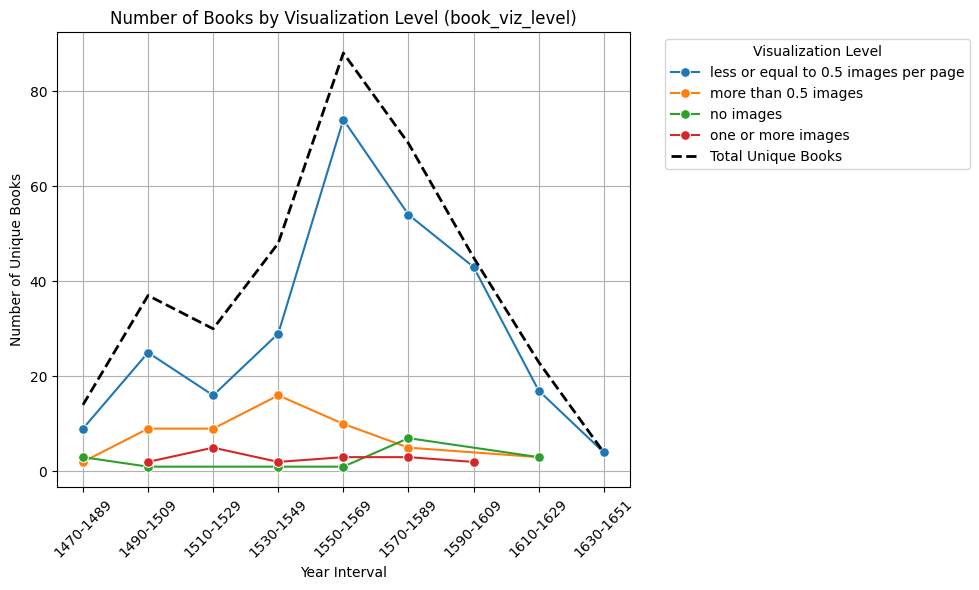

In [119]:
# Step 1: Convert the 'year' column to integer (if not already done), handling errors
merged_df['year'] = pd.to_numeric(merged_df['year'], errors='coerce')

# Define bins and labels for year intervals
bins = [1470, 1490, 1510, 1530, 1550, 1570, 1590, 1610, 1630, 1650]
labels = [
    '1470-1489', '1490-1509', '1510-1529', '1530-1549',
    '1550-1569', '1570-1589', '1590-1609', '1610-1629', '1630-1651'
]

# Use pd.cut to categorize the years into 20-year intervals
merged_df['year_interval'] = pd.cut(merged_df['year'], bins=bins, labels=labels, right=False, include_lowest=True)

# Step 2: Grouping by book_viz_level and year_interval, then counting unique 'book' values
# Set observed=False to avoid the warning, and ensure zero values are removed later
grouped_viz_level = merged_df.groupby(['book_viz_level', 'year_interval'], observed=False)['book'].nunique().reset_index()

# Step 3: Calculate the total number of unique books for each year_interval in merged_df
total_unique_books = merged_df.groupby('year_interval', observed=False)['book'].nunique().reset_index()
total_unique_books['book_viz_level'] = 'Total'  # Label the total line for clarity

# Step 4: Filter out zero values from both `grouped_viz_level` and `total_unique_books` DataFrames
grouped_viz_level = grouped_viz_level[grouped_viz_level['book'] > 0]
total_unique_books = total_unique_books[total_unique_books['book'] > 0]

# Step 5: Create the line plot
plt.figure(figsize=(10, 6))

# Plot for book_viz_level
sns.lineplot(data=grouped_viz_level, x='year_interval', y='book', hue='book_viz_level', marker='o', linestyle='-', markersize=7)

# Plot the broken black line for the total number of unique books
sns.lineplot(data=total_unique_books, x='year_interval', y='book', color='black', linestyle='--', label='Total Unique Books', linewidth=2)

# Step 6: Customize the plot
plt.title('Number of Books by Visualization Level (book_viz_level)')
plt.xlabel('Year Interval')
plt.ylabel('Number of Unique Books')

# Add grid for better readability
plt.grid(True)

# Rotate X-axis labels for better readability
plt.xticks(rotation=45)

# Adjust legend and layout
plt.legend(title='Visualization Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()
